# Prova Final - Machine Learning

**Nome do aluno**: <font color='red'>João Gabriel Faus Faraco</font>

Você deve submeter o trabalho via Blackboard. É de sua responsabilidade garantir que o arquivo correto foi enviado.

Se você precisou adicionar arquivos extras à essa prova, assegure-se de que você os está enviando também.

A prova é individual e com consulta - pode consultar suas anotações, a web, o que quiser, menos perguntar para outros ou para as AIs. Faça o seu trabalho de maneira ética!

ChatGPT para perguntas teóricas não é permitido. CoPilot para código é permitido.

## Instruções

Nesta prova vamos trabalhar com um dataset de informações acerca dos hábitos de pessoas que frequentam uma academia de ginástica.

As questões estão distribuidas ao longo do notebook, procure pela tag "**QUESTÕES**". Temos 5 questões ao todo, com vários sub-itens, somando 11 pontos! (Mas a prova satura em 10, ok?)

Boa prova!

***

# Parte 1: leitura de dados, separação treino-teste, EDA

Não temos questões nessa parte.

### Leitura dos dados

In [1]:
# Código para leitura dos dado, não esqueça de rodar!

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display


def read_data() -> tuple[pd.DataFrame, list[str], list[str], str]:
    """
    Lê o dataset de treino de membros da academia e retorna o DataFrame, 
    colunas categóricas, colunas numéricas e a coluna alvo.
    """
    cat_columns = [
        'Gender',
        'Workout_Type',
        'Experience_Level',
    ]
    num_columns = [
        'Weight (kg)',
        'Height (m)',
        'Max_BPM',
        'Avg_BPM',
        'Resting_BPM',
        'Session_Duration (hours)',
        'Fat_Percentage',
        'Water_Intake (liters)',
        'Workout_Frequency (days/week)',
        'BMI',
    ]
    target_column = 'Calories_Burned'
    dataset = pd.read_csv('gym_members_exercise_tracking.csv')
    return dataset, cat_columns, num_columns, target_column

In [2]:
dataset, cat_columns, num_columns, target_column = read_data()

### Separação treino-teste

In [3]:
from sklearn.model_selection import train_test_split

SEED = 42
test_size = 0.2

train_dataset, test_dataset = train_test_split(
    dataset,
    test_size=test_size,
    random_state=SEED,
)

### EDA

In [4]:
for column in cat_columns:
    display(dataset[column].value_counts().sort_index())

Gender
Female    462
Male      511
Name: count, dtype: int64

Workout_Type
Cardio      255
HIIT        221
Strength    258
Yoga        239
Name: count, dtype: int64

Experience_Level
1    376
2    406
3    191
Name: count, dtype: int64

In [6]:
display(dataset[num_columns] \
    .describe() \
    .transpose() \
    .style \
    .format({ \
        'mean': '{:.2f}', \
        'std': '{:.2f}', \
        'min': '{:.2f}', \
        '25%': '{:.2f}', \
        '50%': '{:.2f}', \
        '75%': '{:.2f}', \
        'max': '{:.2f}', \
    }) \
    .set_table_attributes('style="width: 50%;"'))


,count,mean,std,min,25%,50%,75%,max
Weight (kg),973.000000,73.85,21.21,40.00,58.10,70.00,86.00,129.90
Height (m),973.000000,1.72,0.13,1.50,1.62,1.71,1.80,2.00
Max_BPM,973.000000,179.88,11.53,160.00,170.00,180.00,190.00,199.00
Avg_BPM,973.000000,143.77,14.35,120.00,131.00,143.00,156.00,169.00
Resting_BPM,973.000000,62.22,7.33,50.00,56.00,62.00,68.00,74.00
Session_Duration (hours),973.000000,1.26,0.34,0.50,1.04,1.26,1.46,2.00
Fat_Percentage,973.000000,24.98,6.26,10.00,21.30,26.20,29.30,35.00
Water_Intake (liters),973.000000,2.63,0.60,1.50,2.20,2.60,3.10,3.70
Workout_Frequency (days/week),973.000000,3.32,0.91,2.00,3.00,3.00,4.00,5.00
BMI,973.000000,24.91,6.66,12.32,20.11,24.16,28.56,49.84


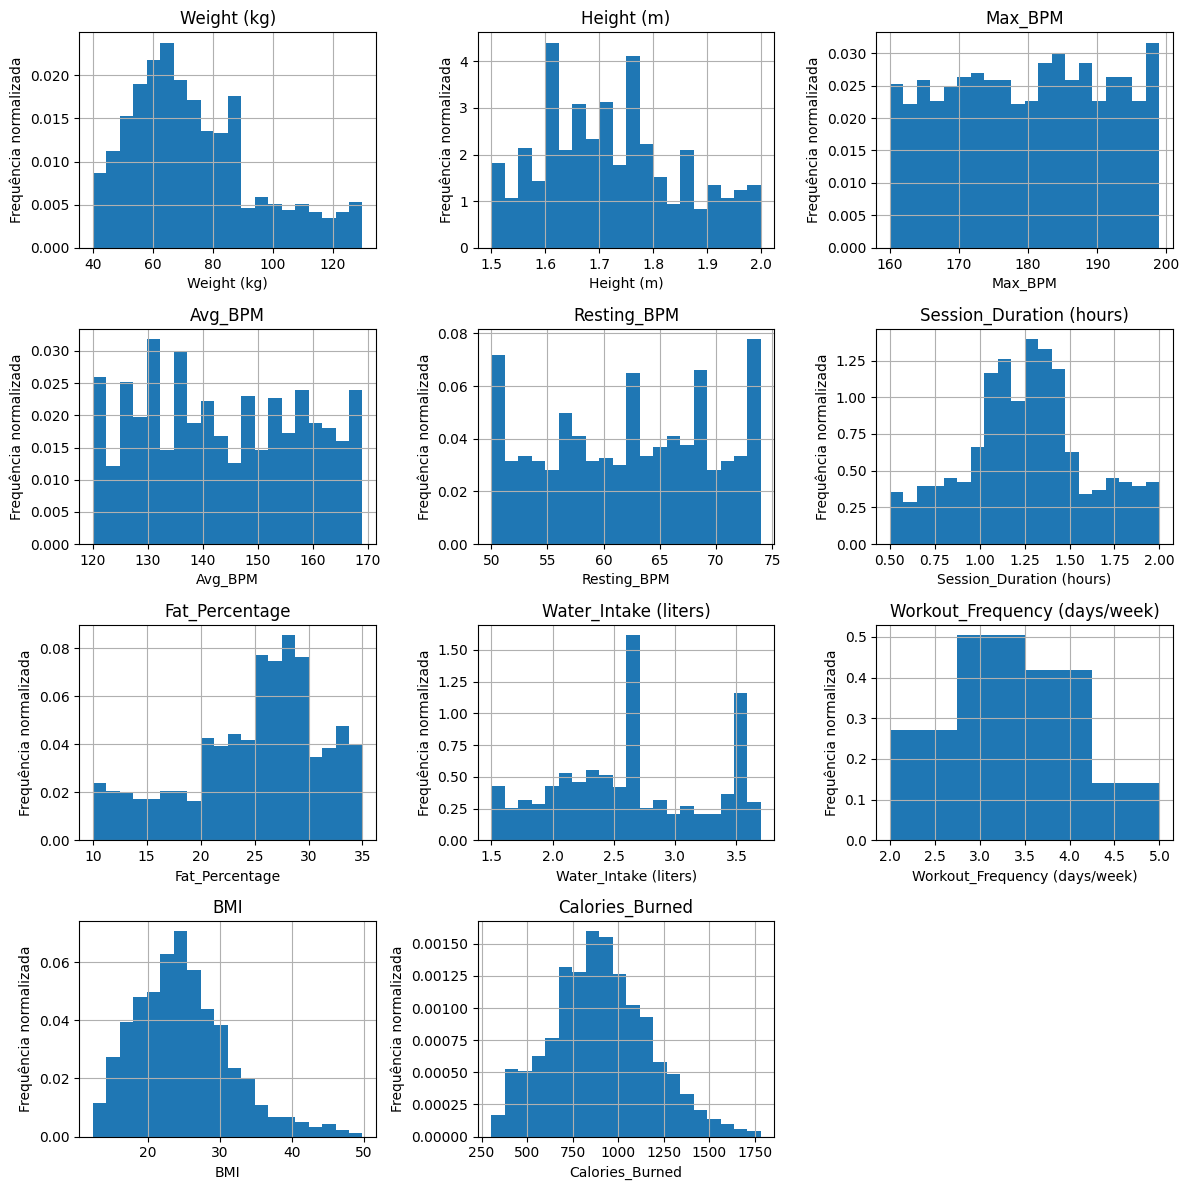

In [7]:
plt.figure(figsize=(12, 12))
for i, column in enumerate(num_columns + [target_column]):
    plt.subplot(4, 3, i + 1)
    plt.title(column)
    plt.xlabel(column)
    plt.ylabel('Frequência normalizada')
    plt.grid()
    plt.hist(
        dataset[column],
        bins=min(20, len(dataset[column].unique())),
        density=True,
    )
plt.tight_layout()
plt.show()


In [8]:
display(train_dataset[num_columns + [target_column]] \
    .corr() \
    .style \
    .background_gradient(cmap='coolwarm', axis=None) \
    .set_table_attributes('style="width: 50%;"') \
    .set_caption('Correlação entre variáveis numéricas'))

,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),BMI,Calories_Burned
Weight (kg),1.000000,0.372351,0.049328,-0.011073,-0.013469,-0.011101,-0.234515,0.408174,0.005948,0.849798,0.095226
Height (m),0.372351,1.000000,-0.057417,-0.017122,-0.000547,-0.009226,-0.238102,0.391995,0.001349,-0.157753,0.087870
Max_BPM,0.049328,-0.057417,1.000000,-0.042396,0.027311,0.030093,-0.013544,0.030548,-0.021016,0.083389,0.019129
Avg_BPM,-0.011073,-0.017122,-0.042396,1.000000,0.070027,0.028216,-0.020048,-0.003184,-0.001472,-0.002203,0.344800
Resting_BPM,-0.013469,-0.000547,0.027311,0.070027,1.000000,0.023454,-0.031448,0.053768,0.020149,-0.013961,0.065211
Session_Duration (hours),-0.011101,-0.009226,0.030093,0.028216,0.023454,1.000000,-0.578470,0.254766,0.639245,-0.003247,0.909383
Fat_Percentage,-0.234515,-0.238102,-0.013544,-0.020048,-0.031448,-0.578470,1.000000,-0.586133,-0.536769,-0.125843,-0.603095
Water_Intake (liters),0.408174,0.391995,0.030548,-0.003184,0.053768,0.254766,-0.586133,1.000000,0.233791,0.229339,0.334206
Workout_Frequency (days/week),0.005948,0.001349,-0.021016,-0.001472,0.020149,0.639245,-0.536769,0.233791,1.000000,0.013200,0.578198
BMI,0.849798,-0.157753,0.083389,-0.002203,-0.013961,-0.003247,-0.125843,0.229339,0.013200,1.000000,0.058568


In [9]:
for column in cat_columns:
    display(train_dataset[num_columns + [target_column, column]] \
        .groupby(column) \
        .mean() \
        .sort_values(target_column) \
        .style \
        .format(precision=2) \
        .set_table_attributes('style="width: 50%;"') \
        .background_gradient(cmap='coolwarm', axis=0) \
        .set_caption(f'Média de {target_column} por {column}'))


,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),BMI,Calories_Burned
Gender,,,,,,,,,,,
Female,60.69,1.64,180.00,143.52,62.04,1.27,27.74,2.21,3.34,22.62,864.50
Male,84.92,1.80,179.74,143.52,62.35,1.25,22.65,3.02,3.33,26.61,938.78


,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),BMI,Calories_Burned
Workout_Type,,,,,,,,,,,
Cardio,74.52,1.72,180.02,143.53,61.59,1.23,25.48,2.64,3.24,25.22,888.52
Yoga,72.89,1.74,180.36,143.39,61.69,1.25,24.59,2.63,3.35,24.08,895.78
Strength,71.96,1.72,179.07,143.74,62.58,1.26,25.57,2.60,3.39,24.40,909.45
HIIT,75.09,1.72,180.12,143.38,62.98,1.29,24.33,2.70,3.36,25.26,923.98


,Weight (kg),Height (m),Max_BPM,Avg_BPM,Resting_BPM,Session_Duration (hours),Fat_Percentage,Water_Intake (liters),Workout_Frequency (days/week),BMI,Calories_Burned
Experience_Level,,,,,,,,,,,
1,72.96,1.73,180.42,143.29,62.07,1.01,27.67,2.55,2.51,24.45,724.78
2,74.15,1.72,178.86,143.71,62.05,1.25,27.32,2.50,3.53,25.04,903.50
3,73.56,1.73,180.98,143.56,62.82,1.75,14.70,3.13,4.54,24.68,1263.68


In [10]:
for column_1 in cat_columns:
    for column_2 in cat_columns:
        if column_1 == column_2:
            continue
        display(pd.crosstab(
            train_dataset[column_1],
            train_dataset[column_2],
            normalize='columns',
        ).style \
            .background_gradient(cmap='coolwarm', axis=0) \
            .set_table_attributes('style="width: 50%;"') \
            .set_caption(f'Porcentagem de {column_1} por {column_2}'))


Workout_Type,Cardio,HIIT,Strength,Yoga
Gender,,,,
Female,0.483254,0.469274,0.478673,0.435754
Male,0.516746,0.530726,0.521327,0.564246


Experience_Level,1,2,3
Gender,,,
Female,0.479866,0.459215,0.463087
Male,0.520134,0.540785,0.536913


Gender,Female,Male
Workout_Type,,
Cardio,0.277473,0.260870
HIIT,0.230769,0.229469
Strength,0.277473,0.265700
Yoga,0.214286,0.243961


Experience_Level,1,2,3
Workout_Type,,,
Cardio,0.295302,0.253776,0.248322
HIIT,0.234899,0.208459,0.268456
Strength,0.261745,0.293051,0.241611
Yoga,0.208054,0.244713,0.241611


Gender,Female,Male
Experience_Level,,
1,0.392857,0.374396
2,0.417582,0.432367
3,0.189560,0.193237


Workout_Type,Cardio,HIIT,Strength,Yoga
Experience_Level,,,,
1,0.421053,0.391061,0.369668,0.346369
2,0.401914,0.385475,0.459716,0.452514
3,0.177033,0.223464,0.170616,0.201117


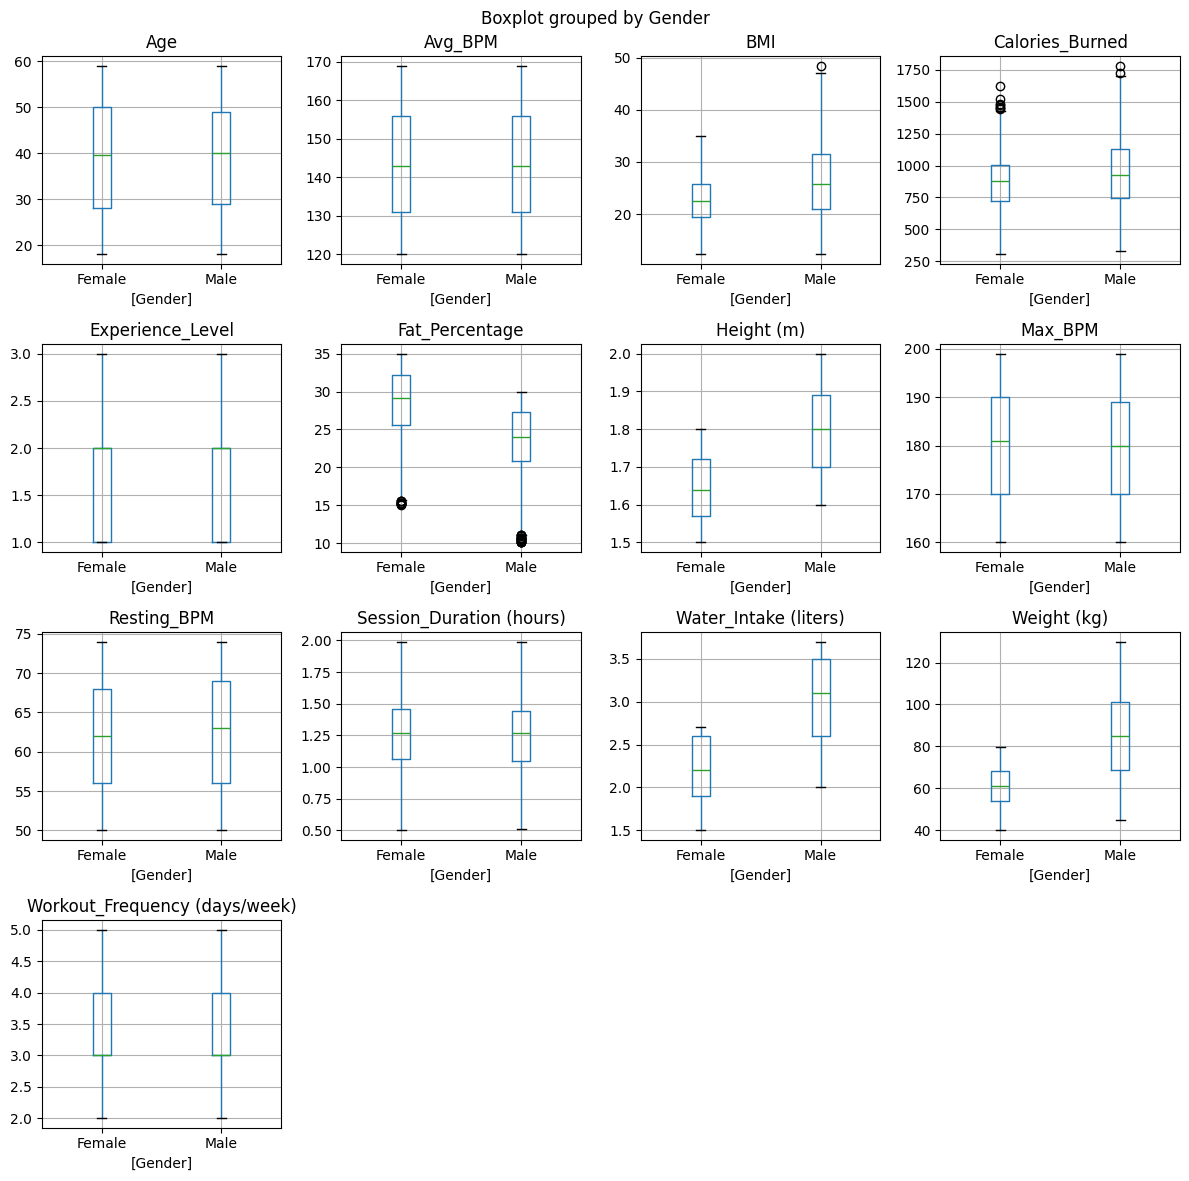

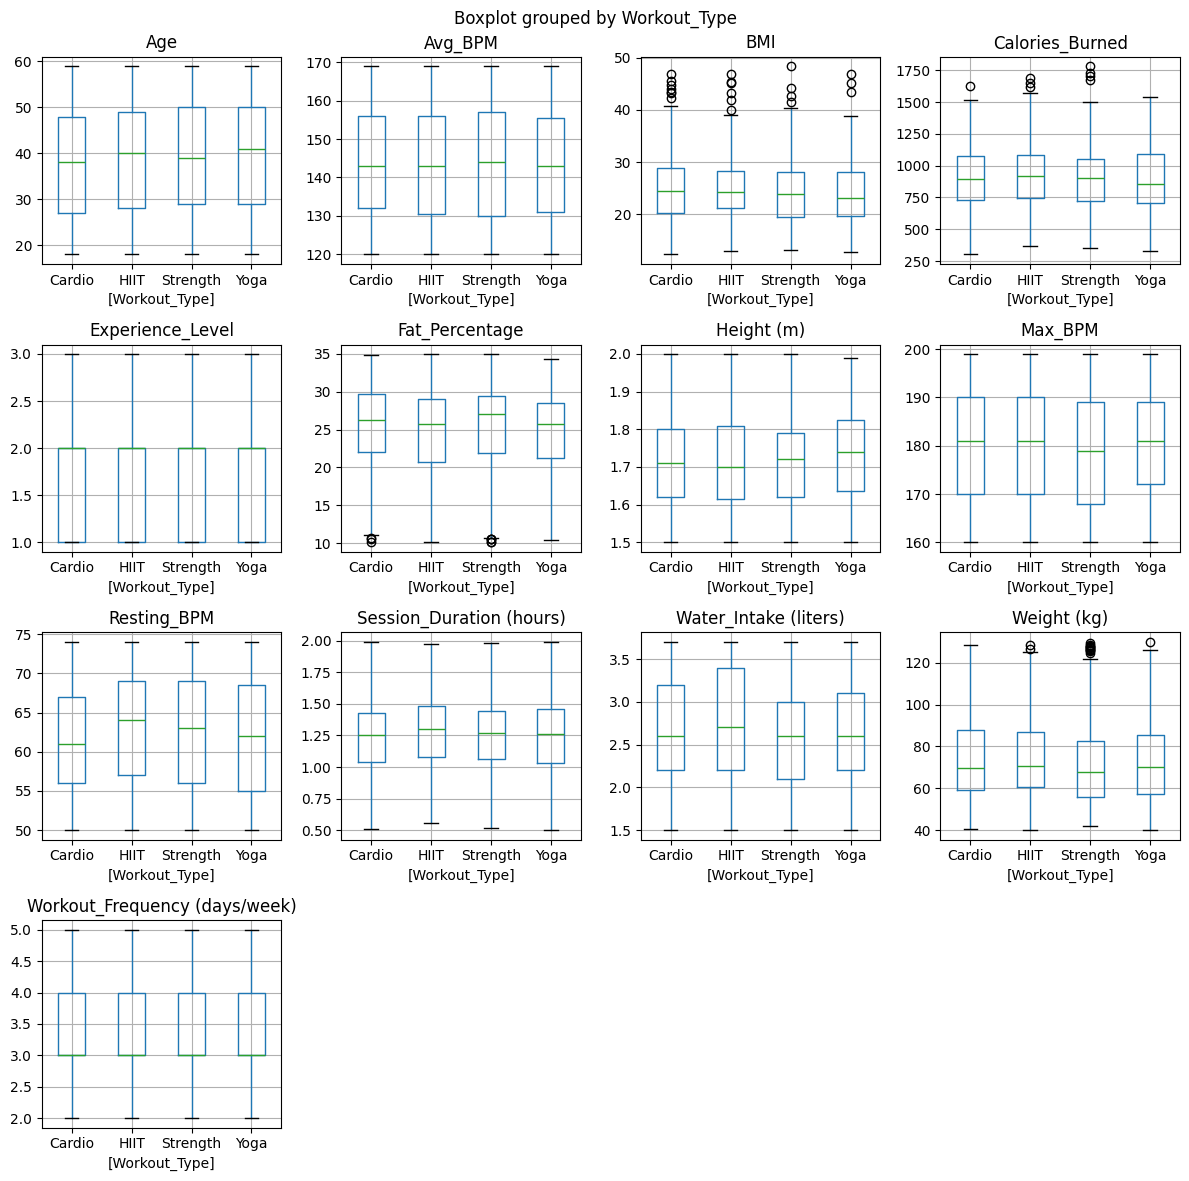

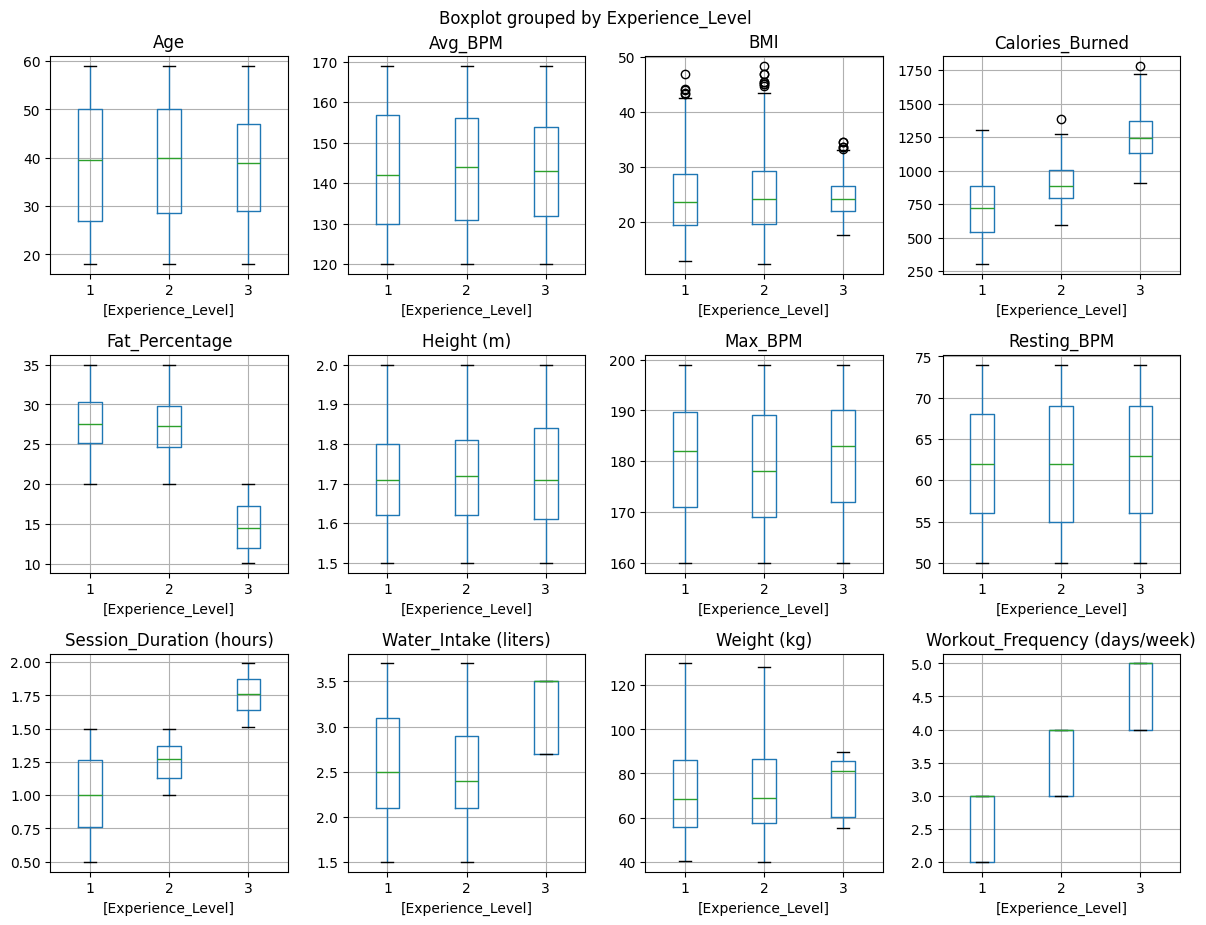

In [11]:
for cat_column in cat_columns:
    train_dataset.boxplot(by=cat_column, layout=(4, 4), sharex=False, sharey=False, figsize=(12, 12))
    plt.tight_layout()

# Parte 2: Aprendizado supervisionado

Nas questões a seguir vamos construir modelos de regressão para prever o gasto calórico em função das várias features do problema.

***

# **QUESTÕES**

***Questão 1*** (1.0 pt)

Construa um modelo do tipo LASSO para fazer seleção das features mais relevantes. Você deve:

- Fazer uma pipeline adequada para um modelo LASSO

- Testar vários valores de `alpha` até obter apenas entre 25% e 50% das features originais com pesos não-nulos.

In [20]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import  Lasso

In [58]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop='first')),
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline,      num_columns),
    ('cat', categorical_pipeline,  cat_columns),
],
remainder='passthrough')

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(alpha=0.02)),
])
model


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Weight (kg)', 'Height (m)',
                                                   'Max_BPM', 'Avg_BPM',
                                                   'Resting_BPM',
                                                   'Session_Duration (hours)',
                                                   'Fat_Percentage',
                                                   'Water_Intake (liters)',
                                                   'Workout_Frequency '
                                                   '(days/week)',
                                                   'BMI']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Workout_Type',
                                                   'Experience_Level'])])),
                ('regressor', Lasso(alpha=0.02))])

In [59]:
model.fit(train_dataset, train_dataset[target_column])
maior_0= 0 
for i in range(73):
    if model['regressor'].coef_[i] > maior_0:
        maior_0+=1
print(maior_0/73)

0.0273972602739726


***

# **QUESTÕES**

***Questão 2***

a) (1.0 pt) Construa um modelo do tipo "Decision Tree" e faça o ajuste de hiperparâmetros. Você deve fazer uma pipeline adequada para este tipo de modelo. Execute o ajuste para obter o melhor modelo - você é que deve determinar o `param_grid`. Mostre os parâmetros do melhor modelo e o seu respectivo desempenho médio de teste de validação cruzada (não é para usar o conjunto de teste, obviamente!).

b) (1.0 pt) Construa um modelo do tipo `sklearn.svm.LinearSVR` e faça o ajuste de hiperparâmetros. Você deve fazer uma pipeline adequada para este tipo de modelo. Execute o ajuste para obter o melhor modelo - você é que deve determinar o `param_grid`. Mostre os parâmetros do melhor modelo e o seu respectivo desempenho médio de teste de validação cruzada (não é para usar o conjunto de teste, obviamente!).

c) (1.0 pt) Construa um modelo do tipo `sklearn.ensemble.RandomForestRegressor` e faça o ajuste de hiperparâmetros. Você deve fazer uma pipeline adequada para este tipo de modelo. Execute o ajuste para obter o melhor modelo - você é que deve determinar o `param_grid`. Mostre os parâmetros do melhor modelo e o seu respectivo desempenho médio de teste de validação cruzada (não é para usar o conjunto de teste, obviamente!).

d) (1.0 pt) Construa um modelo do tipo `sklearn.dummy.DummyRegressor`. Não vai fazer ajuste de hiperparâmetros aqui. Você deve fazer uma pipeline adequada para este tipo de modelo. Execute a medida de desempenho no conjunto de treino com `cross_val_score`.

e) (0.5 pt) Para o melhor modelo dentre os itens anteriores, execute a etapa de certificação do modelo (treina no treino, testa no teste) e apresente o desempenho obtido.

f) (0.5 pt) Plote as predições versus os valores reais no conjunto de teste para ver se existe um bom ajuste.

# A

In [61]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

In [170]:
param_grid_preprocessing = {
    'preprocessor__num__poly__degree': [1, 2]
}
model_param_grid = {
    'tree__max_depth': [3,None],
    'tree__min_samples_split': [ 5, 10],
    'tree__min_samples_leaf': [1, 2]
}

In [172]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop='first')),
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline,      num_columns),
    ('cat', categorical_pipeline,  cat_columns),
],
remainder='passthrough')


model_tree =  Pipeline([
        ('preprocessor', preprocessor),
        ('tree', DecisionTreeRegressor(random_state=SEED)),
    ])

In [173]:
param_grid={
        **param_grid_preprocessing,
        **model_param_grid,
    }

In [174]:
grid_search_DecisionTree = GridSearchCV(
   estimator= model_tree,
    param_grid = param_grid,
    cv=5,
    
    scoring='neg_mean_absolute_error',
    return_train_score=True,
    n_jobs=-1,

)
grid_search_DecisionTree.fit(train_dataset, train_dataset[target_column])

/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['Weight '
                                                                          '(kg)',
                                                                          'Height '
                                                                          '(m)',
                                                                          'Max_BPM',
                                                                          'Avg_BPM',
                                                                          'Resting_BPM',
                                                                          'Session_Duration '
                                                                          '(hours)',
                                                                          'Fat_Percentage',
                                                                          'Water_Intake '
                                                                          '(liters)'...
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Gender',
                                                                          'Workout_Type',
                                                                          'Experience_Level'])])),
                                       ('tree',
                                        DecisionTreeRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'preprocessor__num__poly__degree': [1, 2],
                         'tree__max_depth': [3, None],
                         'tree__min_samples_leaf': [1, 2],
                         'tree__min_samples_split': [5, 10]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [180]:
grid_search_DecisionTree.best_params_

{'preprocessor__num__poly__degree': 1,
 'tree__max_depth': None,
 'tree__min_samples_leaf': 2,
 'tree__min_samples_split': 5}

In [185]:
grid_search_DecisionTree.best_score_

np.float64(-3.4387944582299417)

***

# B

In [126]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [181]:
param_grid_preprocessing = {
    'preprocessor__num__poly__degree': [1, 2],
}
model_param_grid = {
    'svc__C': [0.01, 0.1, 1, 10],
}

In [182]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop='first')),
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline,      num_columns),
    ('cat', categorical_pipeline,  cat_columns),
],
remainder='passthrough')


model_svc =  Pipeline([
        ('preprocessor', preprocessor),
        ('svc', LinearSVC(random_state=SEED)),
    ])

In [183]:
param_grid={
        **param_grid_preprocessing,
        **model_param_grid,
    }

In [184]:
grid_search_SVC = GridSearchCV(
   estimator= model_svc,
    param_grid = param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,

)
grid_search_SVC.fit(train_dataset, train_dataset[target_column])

/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False)),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Weight '
                                                                          '(kg)',
                                                                          'Height '
                                                                          '(m)',
                                                                          'Max_BPM',
                                                                          'Avg_BPM',
                                                                          'Resting_BPM',
                                                                          'Session_Duration '
                                                                          '(hours)',
                                                                          'Fat_Percenta...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Gender',
                                                                          'Workout_Type',
                                                                          'Experience_Level'])])),
                                       ('svc', LinearSVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'preprocessor__num__poly__degree': [1, 2],
                         'svc__C': [0.01, 0.1, 1, 10]},
             scoring='neg_mean_absolute_error')

In [138]:
grid_search_SVC.best_params_

{'preprocessor__num__poly__degree': 2, 'svc__C': 0.01}

In [139]:
grid_search_SVC.best_score_

np.float64(-117.72196856906535)

# C

In [140]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestRegressor

In [146]:
param_grid_preprocessing = {
    'preprocessor__num__poly__degree': [1, 2],
}
model_param_grid = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [3, None],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2],
}

In [147]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop='first')),
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline,      num_columns),
    ('cat', categorical_pipeline,  cat_columns),
],
remainder='passthrough')


model_rf =  Pipeline([
        ('preprocessor', preprocessor),
        ('rf', RandomForestRegressor(random_state=SEED)),
    ])

In [148]:
param_grid={
        **param_grid_preprocessing,
        **model_param_grid,
    }

In [149]:
grid_search_rf = GridSearchCV(
   estimator= model_rf,
    param_grid = param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,

)
grid_search_rf.fit(train_dataset, train_dataset[target_column])

/Users/jgfaraco/miniconda3/lib/python3.12/site-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures(include_bias=False))]),
                                                                         ['Weight '
                                                                          '(kg)',
                                                                          'Height '
                                                                          '(m)',
                                                                          'Max_BPM',
                                                                          'Avg_BPM',
                                                                          'Resting_BPM',
                                                                          'Session_Duration '
                                                                          '(hours)',
                                                                          'Fat_Percentage',
                                                                          'Water_Intake '
                                                                          '(liters)'...
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['Gender',
                                                                          'Workout_Type',
                                                                          'Experience_Level'])])),
                                       ('rf',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'preprocessor__num__poly__degree': [1, 2],
                         'rf__max_depth': [3, None],
                         'rf__min_samples_leaf': [1, 2],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [50, 100]},
             scoring='neg_mean_absolute_error')

In [150]:
grid_search_rf.best_params_

{'preprocessor__num__poly__degree': 1,
 'rf__max_depth': None,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 100}

In [151]:
grid_search_rf.best_score_

np.float64(-1.970421393120024)

# D

In [188]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score

In [200]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop='first')),
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline,      num_columns),
    ('cat', categorical_pipeline,  cat_columns),
],
remainder='passthrough')


model_dummy =  Pipeline([
        ('preprocessor', preprocessor),
        ('dummy', DummyRegressor(strategy='mean')),
    ])

In [201]:
dummy_cv = cross_val_score(
    model_dummy,
    train_dataset,
    train_dataset[target_column],
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
)
dummy_cv.max()

np.float64(-196.31630802209585)

# O melhor foi o Random Forest
# E

In [232]:
from sklearn.metrics import mean_squared_error

In [229]:
grid_search_rf.best_estimator_.fit(train_dataset, train_dataset[target_column])
y_pred_train = model.predict(train_dataset)
mse_train = mean_squared_error(train_dataset[target_column], y_pred_train)
print(f'Mean Squared Error, train: {mse_train=:.2f}')


Mean Squared Error, train: mse_train=0.09


In [230]:
y_pred = grid_search_rf.best_estimator_.predict(test_dataset)
mse_test = mean_squared_error(y_pred, test_dataset[target_column])
print(f'Mean Squared Error, test: {mse_test=:.2f}')

Mean Squared Error, test: mse_test=29.19


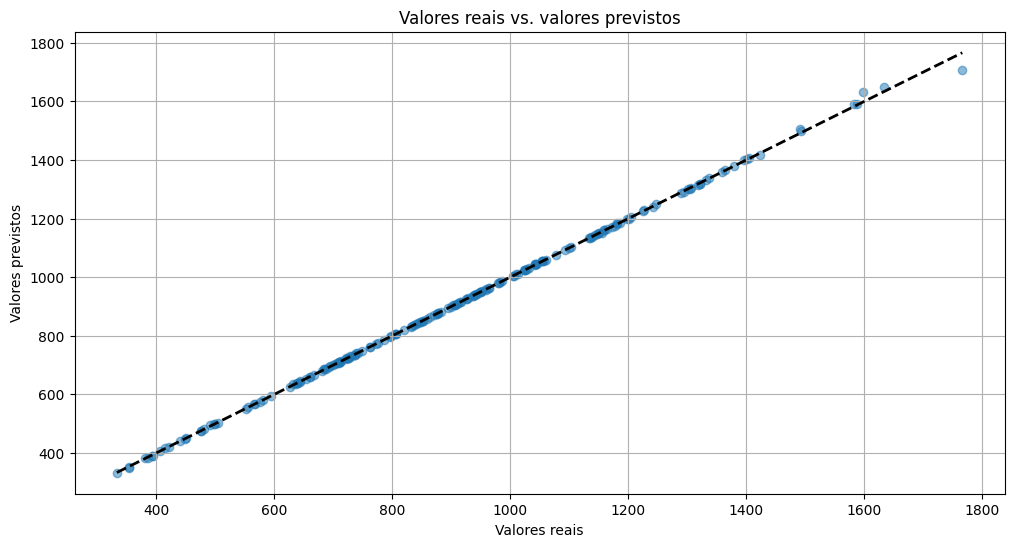

In [231]:
#
plt.figure(figsize=(12, 6))
plt.scatter(test_dataset[target_column], y_pred, alpha=0.5)
plt.title('Valores reais vs. valores previstos')
plt.xlabel('Valores reais')
plt.ylabel('Valores previstos')
plt.grid()
plt.plot(
    [test_dataset[target_column].min(), test_dataset[target_column].max()],
    [test_dataset[target_column].min(), test_dataset[target_column].max()],
    'k--',
    lw=2,
)


# **QUESTÕES**

***Questão 3*** Teoria

a) (0.5 pt) Explique porque a técnica de Support Vector Machines tende ao overfitting se o parâmetro de penalidade $C$ é alto, e porque tende ao underfitting se ele é baixo.

b) (0.5 pt) Explique porque em geral o *bagging* permite treinamento em paralelo e o *boosting* (qualquer um: AdaBoost, Gradient Boosting, etc) não permite

c) (0.5 pt) Explique porque uma árvore de decisão não requer normalização dos dados

a) Caso o o parâmetro de penalidade C de uma SVM for muito alto, para um problema de regressão por exemplo, então a penalidade para pontos fora da avenida vai ser muito alta, portanto o modelo vai fazer de tudo para encaixar todos os pontos dentro da avenida, o que acarreta numa generalização ruim portanto, overfitting. Caso o C seja muito baixo, de novo para um problema de regressão, muitos pontos vão poder ficar fora da avenida, já que são pouco penalizados, portanto  o modelo tende a underfittar.

b) o bagging é um voting classifier, portanto, treinamos n modelos e para um problema de classificação por exemplo, escolhemos a classe que foi mais votada para prever(hard) ou tiramos uma média do predict_proba() (caso o classificador tiver) para prever aquele dado. Portanto, podemos executar os modelos em paralelo, já que esses são independentes. Já modelos de boosting, funiconam como uma sequênica de modelos, portanto primeiro um modelo é executado, e o output desse modelo e o erros que cometeu é usado para ajustar o próximo modelo e assim em diante. Portanto nesse caso os modelos funcionam em sequência, e dependem do output do anterior, portanto não podemos executar em paralelo o treinamento.

c) A árvore de decisão faz  n "splits" nos nossos dados a fim de diminuir o gini ou a entropia. Ela não requer normalização de dados já que não trabalha com distâncias entre datapoints, apenas com esses "splits"

***

# Parte 3: Aprendizado não supervisionado

Nesta parte não vamos identificar nenhum *target*, nosso foco é na análise não-supervisionada do dataset completo.

***

# **QUESTÕES**

***Questão 4***

a) (0.5 pt) Construa uma pipeline que transforma o dataset completo em um dataset que apresenta valores apropriados para executar uma PCA. Por exemplo: as variáveis categóricas vão precisar de one-hot encoding. O que mais é necessário? Você deve mostrar seu conhecimento.

b) (0.5 pt) Vamos aplicar a PCA no dado transformado, com apenas 2 componentes. O código abaixo faz esse serviço para um dataset transformado `X_transf`:

```Python
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transf)
```

Faça um scatter plot das componentes principais (as colunas de `X_pca`)

c) (1.0 pt) Execute uma clusterização com KMeans em `X_pca` para várias escolhas de k: 2, 3, 4, 5 e 6. Para cada valor de k visualize o scatter plot de `X_pca` colorido pelos *labels* de cluster. Visualmente, qual a melhor escolha?

Dica: 

```Python
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_pca)
labels = kmeans.labels_
```

d) (0.5 pt) Como você usaria a informação do clustering para identificar o perfil de clientes da academia em cada cluster? Não precisa implementar, é só uma pergunta qualitativa, precisa explicar.

In [204]:
from sklearn.decomposition import PCA



In [202]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot',  OneHotEncoder(handle_unknown='ignore', sparse_output=False,drop='first')),
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipeline,      num_columns),
    ('cat', categorical_pipeline,  cat_columns),
],
remainder='passthrough')
X_transf = preprocessor.fit_transform(train_dataset)

In [211]:
# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_transf)

Text(0, 0.5, 'Componente Principal 2')

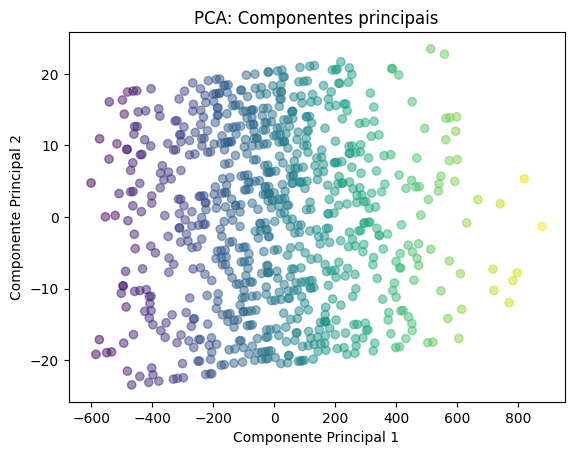

In [212]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=train_dataset[target_column], cmap='viridis', alpha=0.5)
plt.title('PCA: Componentes principais')
plt.xlabel('Componente Principal 1')   
plt.ylabel('Componente Principal 2')

In [214]:
from sklearn.cluster import KMeans

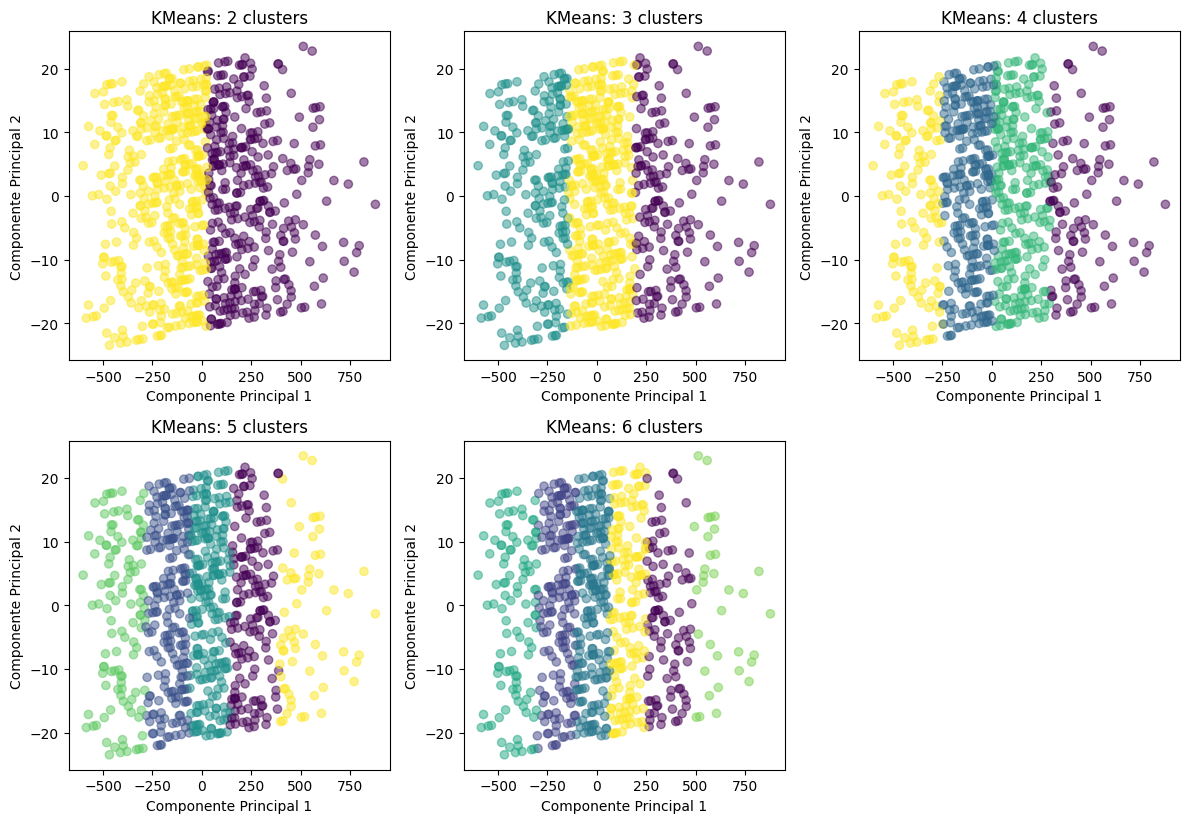

In [228]:
plt.figure(figsize=(12, 12))
for i in range(2,7):
    plt.subplot(3,3, i-1)
    plt.title(f'KMeans: {i} clusters')
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    labels = kmeans.labels_
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
plt.tight_layout()

Eu veria as classes e valores médios das features de cada cluster, a partir dai construiria personas diferentes com essas categorias mais frequentes

***Questão bonus*** (1.0 pt)

As redes neurais já deixaram de ser primariamente inspiradas pela biologia já faz muito tempo. Hoje em dia as redes neurais são apenas funções bem flexíveis do tipo $y = f(x, \theta)$, e são aplicadas nos mais diversos contextos. Considere um par de redes neurais $f$ e $g$ para fazer o seguinte:

$$
z = f(x, \theta_f)
\hat{x} = g(z, \theta_g)
$$

Ou seja, estamos prevendo $x$ com ele mesmo! Imagine, contudo, que o número de features em $z$ é bem menor que aquele em $x$ - um gargalo de informação. Este modelo é chamado *autoencoder*, e realiza redução de dimensionalidade.

Qual a diferença entre um *autoencoder* com redes neurais e uma PCA?


Com PCA para fazer redução de dimensionalidade, criamos n(n é a quantidade de dimensões) vetores que melhor se ajustam para os dados, e "trazemos" os dados para esse vetor, mantendo a distância deles em relação a origem. Depois atribuimos um porcentagem para cada vetor que representa o "peso" desse vetor para como esses dados se comportam, ou seja, quais dimensões contém a "essência" daqueles dados? A grande questão é que não conseguimos voltar para o plano original após aplicarmos o PCA. Já o autoencoder, ele utiliza backpropagation para otimizar o erro quadrático, e além disso, conseguimos voltar para a dimensão original do X.


Boa prova!